In [1]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from utils.plot_utils import set_fontsize
from utils.hdf_utils import load_measurement_data_devices

In [2]:
fname = "2020_3_17.hdf"
dset_names = [
    "1584460214 noise_check_rotational_cooling_only",
    "1584460293 noise_check_detection_only",
    "1584460337 noise_check_no_lasers",
    "1584460392 noise_check_all_lasers"
]
devices = ('Laser Lock', 'Wavelength', 'ZaberTMM')

In [3]:
pmt_channel = 2
pxie_data = {}
for dset_name in dset_names:
    pxie, pxie_time, data_devices = load_measurement_data_devices(fname, dset_name, devices)
    pxie_data[dset_name] = [dat[:,pmt_channel] for dat in pxie.values()]

In [4]:
data = [np.mean(dat, axis = 0) for dat in pxie_data.values()]

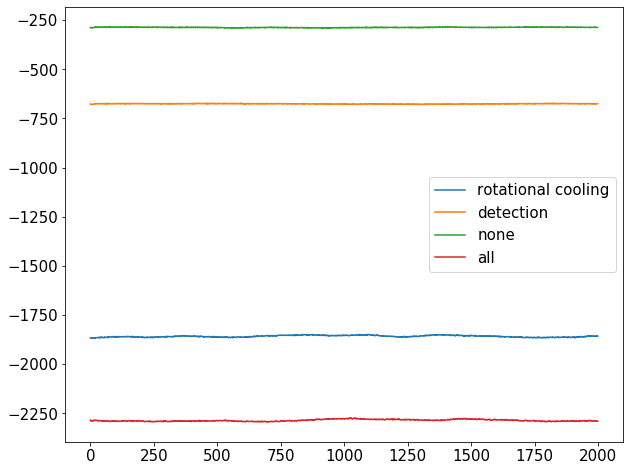

In [5]:
data_names = ['rotational cooling', 'detection', 'none', 'all']
fig, ax = plt.subplots(figsize = (10,8))
for dat_name, dat in zip(data_names, data):
    ax.plot(dat, label = dat_name)
ax.legend(fontsize = 15)
set_fontsize(ax, 15)

In [6]:
(data[1]-data[2]).mean()

-388.6039934930494

In [7]:
(data[3]-data[0]).mean()

-427.60163489461365

In [8]:
(data[3]-data[0]).mean()/(data[1]-data[2]).mean()

1.1003531668602415

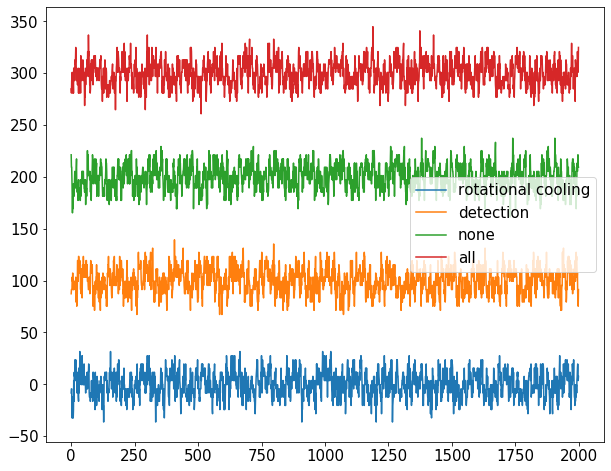

In [69]:
fig, ax = plt.subplots(figsize = (10,8))
for idx, (dset_name, label) in enumerate(zip(pxie_data.keys(), data_names)):
    ax.plot(pxie_data[dset_name][0] - pxie_data[dset_name][0].mean()+100*idx, label = label)
ax.legend(fontsize = 15)
set_fontsize(ax, 15)

In [70]:
for dset_name, label, dat in zip(pxie_data.keys(), data_names, data):
    print(f"{label:>18} : {dat.mean():>8.2f} [adc]")

rotational cooling :  -284.75 [adc]
         detection :  -423.82 [adc]
              none :  -342.81 [adc]
               all :  -482.30 [adc]


### Sinusoidal 250Hz 50 mVpp on SR445A amplifier input with varying offsets
Checking if amplifier gain is dependent on input offset

In [71]:
fname = "2020_3_17.hdf"
dset_names = [
    "1584474869 250Hz_50mVpp_-200mVoffset_47dB_attenuator",
    "1584474922 250Hz_50mVpp_0mVoffset_47dB_attenuator",
    "1584474973 250Hz_50mVpp_-100mVoffset_47dB_attenuator",
    "1584475016 250Hz_50mVpp_-400mVoffset_47dB_attenuator",
    "1584475069 250Hz_50mVpp_-500mVoffset_47dB_attenuator"
]
devices = ()

In [72]:
pmt_channel = 2
pxie_data = {}
for dset_name in dset_names:
    pxie, pxie_time, data_devices = load_measurement_data_devices(fname, dset_name, devices)
    pxie_data[dset_name] = [dat[:,pmt_channel] for dat in pxie.values()]

In [73]:
offsets = [-200,0,-100,-400,-500]
traces_ptp = {}
traces_mean = {}
for offset, dset_name in zip(offsets, dset_names):
    traces_ptp[offset] = [dat.ptp() for dat in pxie_data[dset_name]]
    traces_mean[offset] = np.mean(pxie_data[dset_name])

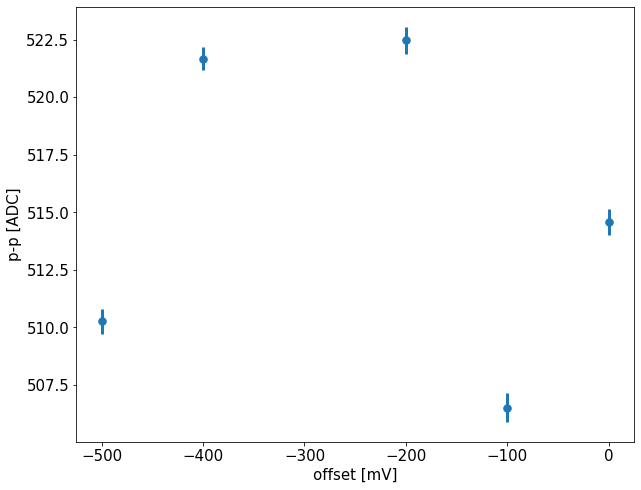

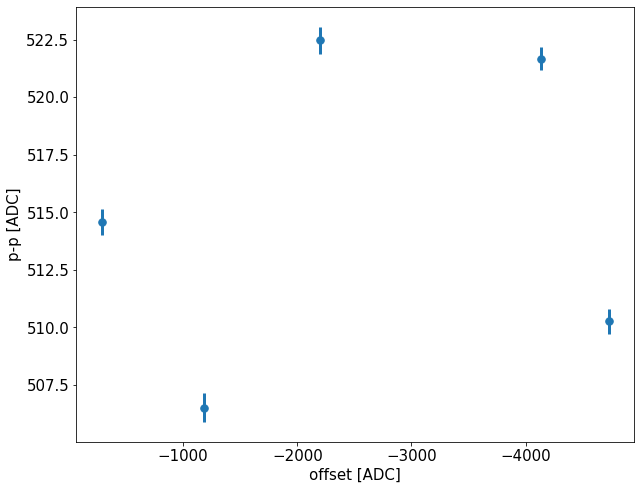

In [74]:
y = [(np.mean(val), np.std(val)/np.sqrt(len(val))) for val in traces_ptp.values()]
y,yerr = zip(*y)

fig, ax = plt.subplots(figsize = (10,8))
ax.errorbar(offsets, y, yerr, fmt = '.', ms = 15, lw = 3)

ax.set_ylabel('p-p [ADC]')
ax.set_xlabel('offset [mV]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (10,8))
ax.errorbar(traces_mean.values(), y, yerr, fmt = '.', ms = 15, lw = 3)
ax.invert_xaxis()

ax.set_ylabel('p-p [ADC]')
ax.set_xlabel('offset [ADC]')
set_fontsize(ax, 15)

## Fixed orientation lowpass filter (previously had input on output and vice-versa

In [101]:
fname = "2020_3_17.hdf"
dset_names = [
    "1584475436 noise_check_pmt_corrected_lowpass_no_light",
    "1584475505 noise_check_pmt_corrected_lowpass_detection",
    "1584475580 noise_check_pmt_corrected_lowpass_rotational_cooling",
    "1584475672 noise_check_pmt_corrected_lowpass_both",
    "1584475776 noise_check_pmt_corrected_lowpass_detection_roomlight",
    "1584475837 noise_check_pmt_corrected_lowpass_roomlight",
    "1584479601 noise_check_pmt_corrected_lowpass_roomlight_rotational_cooling",
    "1584479664 noise_check_pmt_corrected_lowpass_roomlight_rotational_cooling_detection"
]
devices = ()

In [102]:
pmt_channel = 2
pxie_data = {}
for dset_name in dset_names:
    pxie, pxie_time, data_devices = load_measurement_data_devices(fname, dset_name, devices)
    pxie_data[dset_name] = [dat[:,pmt_channel] for dat in pxie.values()]
    
data = [np.mean(dat, axis = 0) for dat in pxie_data.values()]
data_err = [np.std(np.mean(dat, axis = 1))/np.sqrt(len(dat)) for dat in pxie_data.values()]

In [108]:
indices = {'no light': (1,0), 'rot light': (3, 2), 'room light': (4, 5), 'all light': (7,6)}

differences = {}
for name, (idx_signal, idx_bg) in indices.items():
    print(f"{dset_names[idx_signal]:<52}, {dset_names[idx_bg]:<50}")
    differences[name] = ((data[idx_signal]-data[idx_bg]).mean(), data[idx_bg].mean())

for name, (diff, bg) in differences.items():
    print(f'difference detection {name:<10}: {diff:<10.2f}; mean offset = {bg:.2f}')
    
ratios = {}
for name, (diff, bg) in list(differences.items())[1:]:
    ratios[name] = (bg, diff / differences['no light'][0])
    print(f'ratio {name} / no light : {diff / differences["no light"][0]:.2f}')

differences_voltage = {'-1000V': differences}
ratios_voltage = {'-1000V': ratios}

1584475505 noise_check_pmt_corrected_lowpass_detection, 1584475436 noise_check_pmt_corrected_lowpass_no_light
1584475672 noise_check_pmt_corrected_lowpass_both   , 1584475580 noise_check_pmt_corrected_lowpass_rotational_cooling
1584475776 noise_check_pmt_corrected_lowpass_detection_roomlight, 1584475837 noise_check_pmt_corrected_lowpass_roomlight
1584479664 noise_check_pmt_corrected_lowpass_roomlight_rotational_cooling_detection, 1584479601 noise_check_pmt_corrected_lowpass_roomlight_rotational_cooling
difference detection no light  : -389.44   ; mean offset = -285.77
difference detection rot light : -457.09   ; mean offset = -1972.05
difference detection room light: -449.73   ; mean offset = -1097.22
difference detection all light : -563.70   ; mean offset = -3000.31
ratio rot light / no light : 1.17
ratio room light / no light : 1.15
ratio all light / no light : 1.45


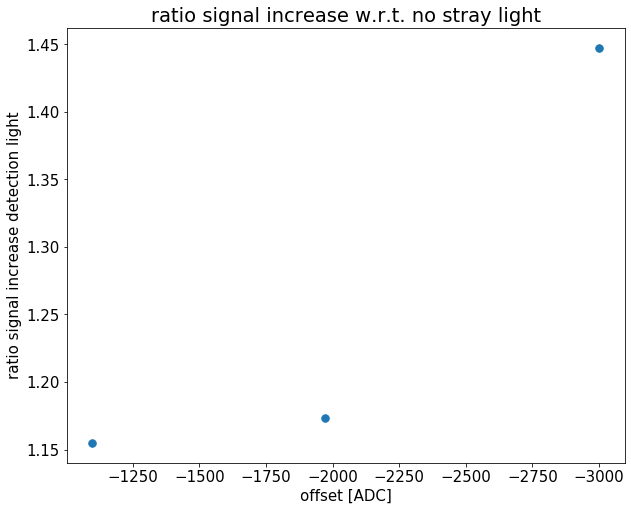

In [109]:
offset, ratio = zip(*ratios.values())

fig, ax = plt.subplots(figsize = (10,8))
ax.plot(offset, ratio, '.', ms = 15)
ax.invert_xaxis()

ax.set_title('ratio signal increase w.r.t. no stray light')
ax.set_xlabel('offset [ADC]')
ax.set_ylabel('ratio signal increase detection light')
set_fontsize(ax, 15)

## Different PMT Voltages

In [110]:
fname = "2020_3_18.hdf"
dset_names = [
                '1584558028 noise_check_no_light_-750V', 
                '1584558093 noise_check_room_light_-750V', 
                '1584558241 noise_check_det_light_-750V', 
                '1584558282 noise_check_det_light_room_light_-750V', 
                '1584558402 noise_check_det_light_rot_light_-750V', 
                '1584558452 noise_check_all_light_-750V', 
                '1584558662 noise_check_rot_light_room_light_-750V', 
                '1584558722 noise_check_rot_light_-750V', 
                '1584558794 noise_check_no_light_-900V', 
                '1584558848 noise_check_no_light_-1100V', 
                '1584558901 noise_check_room_light_-1100V', 
                '1584558971 noise_check_room_light_-900V', 
                '1584559107 noise_check_det_light_room_light_-900V', 
                '1584559165 noise_check_det_light_room_light_-1100V', 
                '1584559229 noise_check_det_light_-1100V', 
                '1584559301 noise_check_det_light_-900V', 
                '1584559374 noise_check_det_light_rot_light_-900V', 
                '1584559433 noise_check_det_light_rot_light_-1100V', 
                '1584559478 noise_check_all_light_-1100V', 
                '1584559527 noise_check_all_light_-900V', 
                '1584559628 noise_check_rot_light_-900V', 
                '1584559695 noise_check_rot_light_-1100V', 
                '1584559769 noise_check_rot_light_room_light_-1100V', 
                '1584559828 noise_check_rot_light_room_light_-900V',
                '1584565859 noise_check_no_light_-800V',
                '1584565948 noise_check_det_light_-800V',
                '1584566006 noise_check_det_light_room_light_-800V',
                '1584566070 noise_check_room_light_-800V', 
                '1584566161 noise_check_all_light_-800V', 
                '1584566225 noise_check_det_light_rot_light_-800V', 
                '1584566291 noise_check_rot_light_-800V', 
                '1584566346 noise_check_rot_light_room_light_-800V',
                '1584566468 noise_check_rot_light_-750V',
                '1584566545 noise_check_det_light_rot_light_-750V'
]
devices = ()

In [111]:
pmt_channel = 2
pxie_data = {}
for dset_name in dset_names:
    pxie, pxie_time, data_devices = load_measurement_data_devices(fname, dset_name, devices)
    pxie_data[dset_name] = [dat[:,pmt_channel] for dat in pxie.values()]
    
data = [np.mean(dat, axis = 0) for dat in pxie_data.values()]
data_err = [np.std(np.mean(dat, axis = 1))/np.sqrt(len(dat)) for dat in pxie_data.values()]

## -750V PMT

In [112]:
indices = {'no light': (2,0), 'rot light': (33, 32), 'room light': (3, 1), 'all light': (5,6)}

differences = {}
for name, (idx_signal, idx_bg) in indices.items():
    print(f"{dset_names[idx_signal]:<52}, {dset_names[idx_bg]:<50}")
    differences[name] = ((data[idx_signal]-data[idx_bg]).mean(), data[idx_bg].mean())

for name, (diff, bg) in differences.items():
    print(f'difference detection {name:<10}: {diff:<10.2f}; mean offset = {bg:.2f}')
    
ratios = {}
for name, (diff, bg) in list(differences.items())[1:]:
    ratios[name] = (bg, diff / differences['no light'][0])
    print(f'ratio {name} / no light : {diff / differences["no light"][0]:.2f}')
    
differences_voltage['-700V'] = differences
ratios_voltage['-750V'] = ratios

1584558241 noise_check_det_light_-750V              , 1584558028 noise_check_no_light_-750V             
1584566545 noise_check_det_light_rot_light_-750V    , 1584566468 noise_check_rot_light_-750V            
1584558282 noise_check_det_light_room_light_-750V   , 1584558093 noise_check_room_light_-750V           
1584558452 noise_check_all_light_-750V              , 1584558662 noise_check_rot_light_room_light_-750V 
difference detection no light  : -58.06    ; mean offset = -284.75
difference detection rot light : -58.36    ; mean offset = -501.57
difference detection room light: -58.48    ; mean offset = -423.82
difference detection all light : -56.73    ; mean offset = -642.91
ratio rot light / no light : 1.01
ratio room light / no light : 1.01
ratio all light / no light : 0.98


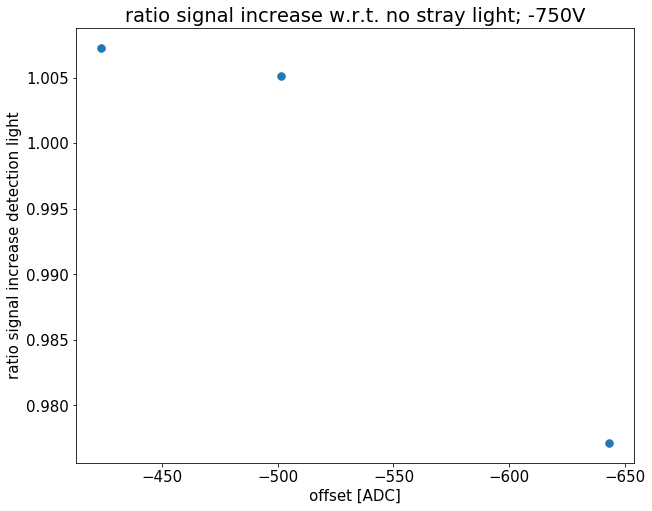

In [113]:
offset, ratio = zip(*ratios.values())

fig, ax = plt.subplots(figsize = (10,8))
ax.plot(offset, ratio, '.', ms = 15)
ax.invert_xaxis()

ax.set_title('ratio signal increase w.r.t. no stray light; -750V')
ax.set_xlabel('offset [ADC]')
ax.set_ylabel('ratio signal increase detection light')
set_fontsize(ax, 15)

## -900V PMT

In [114]:
indices = {'no light': (15,8), 'rot light': (16, 20), 'room light': (12, 11), 'all light': (19,23)}

differences = {}
for name, (idx_signal, idx_bg) in indices.items():
    print(f"{dset_names[idx_signal]:<52}, {dset_names[idx_bg]:<50}")
    differences[name] = ((data[idx_signal]-data[idx_bg]).mean(), data[idx_bg].mean())

for name, (diff, bg) in differences.items():
    print(f'difference detection {name:<10}: {diff:<10.2f}; mean offset = {bg:.2f}')
    
ratios = {}
for name, (diff, bg) in list(differences.items())[1:]:
    ratios[name] = (bg, diff / differences['no light'][0])
    print(f'ratio {name} / no light : {diff / differences["no light"][0]:.2f}')

differences_voltage['-900V'] = differences
ratios_voltage['-900V'] = ratios

1584559301 noise_check_det_light_-900V              , 1584558794 noise_check_no_light_-900V             
1584559374 noise_check_det_light_rot_light_-900V    , 1584559628 noise_check_rot_light_-900V            
1584559107 noise_check_det_light_room_light_-900V   , 1584558971 noise_check_room_light_-900V           
1584559527 noise_check_all_light_-900V              , 1584559828 noise_check_rot_light_room_light_-900V 
difference detection no light  : -189.66   ; mean offset = -284.26
difference detection rot light : -192.36   ; mean offset = -972.54
difference detection room light: -199.10   ; mean offset = -708.00
difference detection all light : -228.41   ; mean offset = -1446.79
ratio rot light / no light : 1.01
ratio room light / no light : 1.05
ratio all light / no light : 1.20


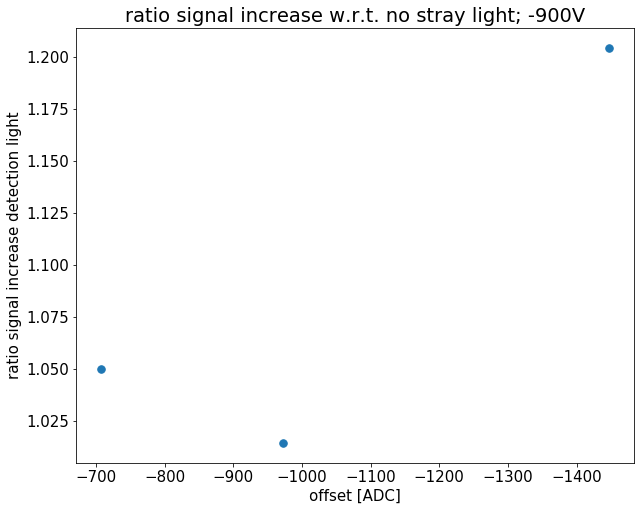

In [115]:
offset, ratio = zip(*ratios.values())

fig, ax = plt.subplots(figsize = (10,8))
ax.plot(offset, ratio, '.', ms = 15)
ax.invert_xaxis()

ax.set_title('ratio signal increase w.r.t. no stray light; -900V')
ax.set_xlabel('offset [ADC]')
ax.set_ylabel('ratio signal increase detection light')
set_fontsize(ax, 15)

## -1100V PMT

In [116]:
indices = {'no light': (14,9), 'rot light': (17, 21), 'room light': (13, 10), 'all light': (18,22)}

differences = {}
for name, (idx_signal, idx_bg) in indices.items():
    print(f"{dset_names[idx_signal]:<52}, {dset_names[idx_bg]:<50}")
    differences[name] = ((data[idx_signal]-data[idx_bg]).mean(), data[idx_bg].mean())

for name, (diff, bg) in differences.items():
    print(f'difference detection {name:<10}: {diff:<10.2f}; mean offset = {bg:.2f}')
    
ratios = {}
for name, (diff, bg) in list(differences.items())[1:]:
    ratios[name] = (bg, diff / differences['no light'][0])
    print(f'ratio {name} / no light : {diff / differences["no light"][0]:.2f}')
    
differences_voltage['-1100V'] = differences
ratios_voltage['-1100V'] = ratios

1584559229 noise_check_det_light_-1100V             , 1584558848 noise_check_no_light_-1100V            
1584559433 noise_check_det_light_rot_light_-1100V   , 1584559695 noise_check_rot_light_-1100V           
1584559165 noise_check_det_light_room_light_-1100V  , 1584558901 noise_check_room_light_-1100V          
1584559478 noise_check_all_light_-1100V             , 1584559769 noise_check_rot_light_room_light_-1100V
difference detection no light  : -733.72   ; mean offset = -286.89
difference detection rot light : -917.88   ; mean offset = -3100.67
difference detection room light: -842.49   ; mean offset = -1819.45
difference detection all light : -1065.65  ; mean offset = -5161.87
ratio rot light / no light : 1.25
ratio room light / no light : 1.15
ratio all light / no light : 1.45


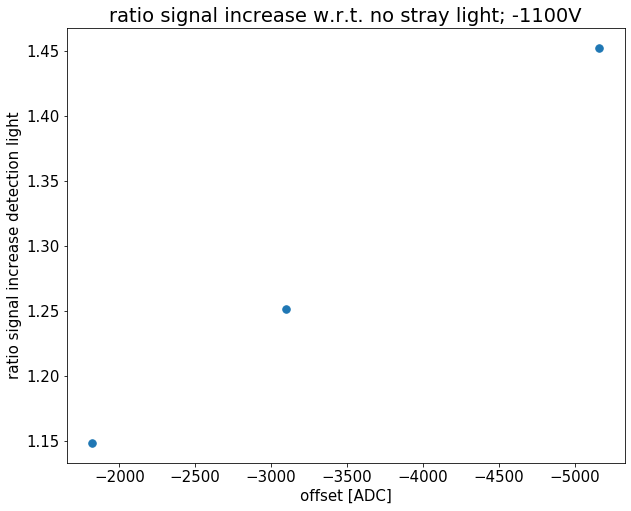

In [117]:
offset, ratio = zip(*ratios.values())

fig, ax = plt.subplots(figsize = (10,8))
ax.plot(offset, ratio, '.', ms = 15)
ax.invert_xaxis()

ax.set_title('ratio signal increase w.r.t. no stray light; -1100V')
ax.set_xlabel('offset [ADC]')
ax.set_ylabel('ratio signal increase detection light')
set_fontsize(ax, 15)

## -800V PMT

In [118]:
indices = {'no light': ('1584565948 noise_check_det_light_-800V','1584565859 noise_check_no_light_-800V'), 
           'rot light': ('1584566225 noise_check_det_light_rot_light_-800V', '1584566291 noise_check_rot_light_-800V'), 
           'room light': ('1584566006 noise_check_det_light_room_light_-800V', '1584566070 noise_check_room_light_-800V'), 
           'all light': ('1584566161 noise_check_all_light_-800V','1584566346 noise_check_rot_light_room_light_-800V')}

differences = {}
for name, (name_signal, name_background) in indices.items():
    idx_signal = dset_names.index(name_signal)
    idx_bg = dset_names.index(name_background)
    print(f"{dset_names[idx_signal]:<52}, {dset_names[idx_bg]:<50}")
    differences[name] = ((data[idx_signal]-data[idx_bg]).mean(), data[idx_bg].mean())

for name, (diff, bg) in differences.items():
    print(f'difference detection {name:<10}: {diff:<10.2f}; mean offset = {bg:.2f}')
    
ratios = {}
for name, (diff, bg) in list(differences.items())[1:]:
    ratios[name] = (bg, diff / differences['no light'][0])
    print(f'ratio {name} / no light : {diff / differences["no light"][0]:.2f}')

differences_voltage['-800V'] = differences
ratios_voltage['-800V'] = ratios

1584565948 noise_check_det_light_-800V              , 1584565859 noise_check_no_light_-800V             
1584566225 noise_check_det_light_rot_light_-800V    , 1584566291 noise_check_rot_light_-800V            
1584566006 noise_check_det_light_room_light_-800V   , 1584566070 noise_check_room_light_-800V           
1584566161 noise_check_all_light_-800V              , 1584566346 noise_check_rot_light_room_light_-800V 
difference detection no light  : -90.46    ; mean offset = -282.90
difference detection rot light : -96.36    ; mean offset = -601.72
difference detection room light: -88.94    ; mean offset = -487.36
difference detection all light : -85.74    ; mean offset = -822.65
ratio rot light / no light : 1.07
ratio room light / no light : 0.98
ratio all light / no light : 0.95


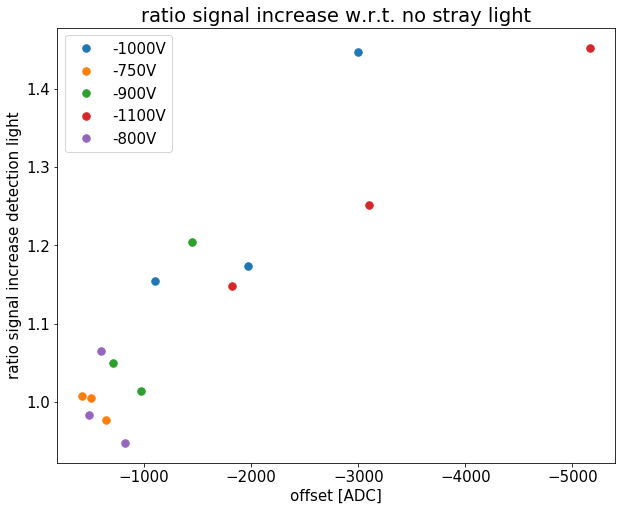

In [119]:
fig, ax = plt.subplots(figsize = (10,8))
for voltage, measurement in ratios_voltage.items():
    o, r = zip(*measurement.values())
    ax.plot(o,r, '.', ms = 15, label = f'{voltage}')
   
ax.legend(fontsize = 15)
ax.set_title('ratio signal increase w.r.t. no stray light')
ax.set_xlabel('offset [ADC]')
ax.set_ylabel('ratio signal increase detection light')
set_fontsize(ax, 15)
ax.invert_xaxis()

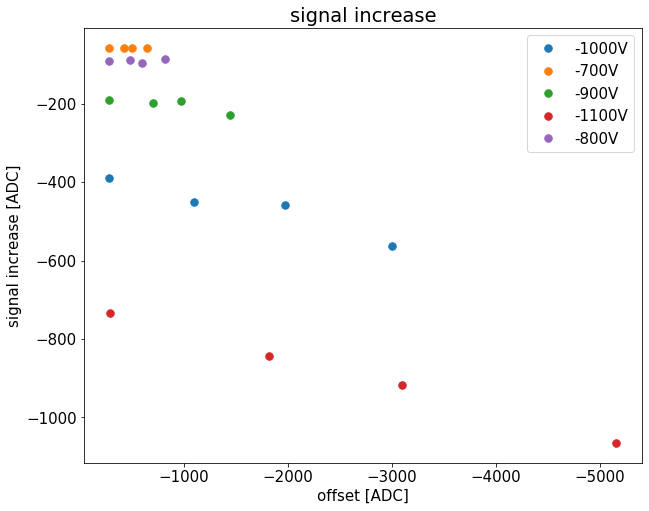

In [121]:
fig, ax = plt.subplots(figsize = (10,8))
for voltage, measurement in differences_voltage.items():
    d, o = zip(*measurement.values())
    ax.plot(o,d, '.', ms = 15, label = f'{voltage}')
   
ax.legend(fontsize = 15)
ax.set_title('signal increase')
ax.set_xlabel('offset [ADC]')
ax.set_ylabel('signal increase [ADC]')
set_fontsize(ax, 15)
ax.invert_xaxis()

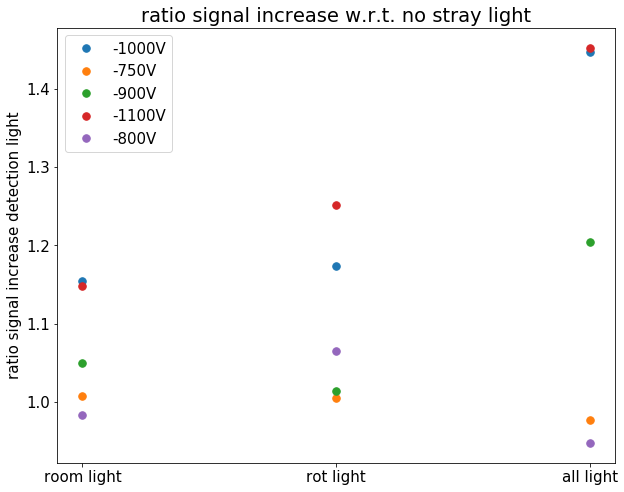

In [146]:
names = ['room light', 'rot light', 'all light']
colors = ['C0', 'C1', 'C2', 'C3', 'C4']

fig, ax = plt.subplots(figsize = (10,8))
for idx, (voltage, measurement) in enumerate(ratios_voltage.items()):
    for idn, name in enumerate(names):
        r = measurement[name][1]
        ax.plot(idn, r, '.', color = colors[idx], ms = 15, label = f'{voltage}')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize = 15)

ax.set_xticks([0,1,2])
ax.set_xticklabels(names)

ax.set_title('ratio signal increase w.r.t. no stray light')
ax.set_ylabel('ratio signal increase detection light')
set_fontsize(ax, 15)
# ax.invert_xaxis()

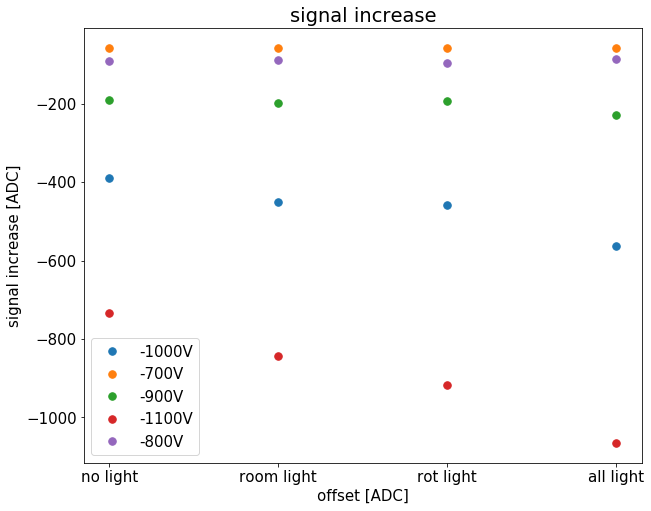

In [150]:
names = ['no light', 'room light', 'rot light', 'all light']
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']

fig, ax = plt.subplots(figsize = (10,8))
for idx, (voltage, measurement) in enumerate(differences_voltage.items()):
    for idn, name in enumerate(names):
        d = measurement[name][0]
        ax.plot(idn, d, '.', color = colors[idx], ms = 15, label = f'{voltage}')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize = 15)

ax.set_xticks([0,1,2,3])
ax.set_xticklabels(names)

ax.set_title('signal increase')
ax.set_xlabel('offset [ADC]')
ax.set_ylabel('signal increase [ADC]')
set_fontsize(ax, 15)